In [1]:
import os

import numpy as np
from skimage.feature import peak_local_max
import progressbar
import matplotlib.pyplot as plt

from utoolbox.container import Volume

### Environment presets

In [2]:
file_path = os.path.join(
    *["data", "20170831_SIM", "SI_b1a2DSIM_os", "summedWF", "RAWb1a2DSIM_os_ch0_stack0000_561nm.tif"]
)

In [3]:
kernel_size = 15
radius = (kernel_size-1) // 2

### Load data

In [4]:
raw = Volume(file_path)
print("shape={}".format(raw.shape))
print("dtype={}".format(raw.dtype))

shape=(101, 512, 512)
dtype=uint16


In [5]:
print("mean={:.2f}, sd={:.2f}".format(np.mean(raw), np.std(raw)))

mean=107.75, sd=19.62


### Find peaks

In [6]:
th = np.mean(raw) + 2*np.std(raw)
coords = peak_local_max(
    raw, exclude_border=radius, min_distance=2*kernel_size, threshold_abs=np.mean(raw)
)

In [7]:
print("{} peaks found".format(len(coords)))

97 peaks found


### Isolate the patches

In [8]:
patches = np.zeros((len(coords), kernel_size, kernel_size), dtype=np.float32)

In [9]:
index = 0
bar = progressbar.ProgressBar()
for coord in bar(coords):
    x = coord[2]
    y = coord[1]
    z = coord[0]
    
    patches[index, ...] = raw[z, y-radius:y+radius+1, x-radius:x+radius+1]
    
    index += 1

100% (97 of 97) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


### Preview

In [10]:
raw_xy = np.amax(raw, axis=0)

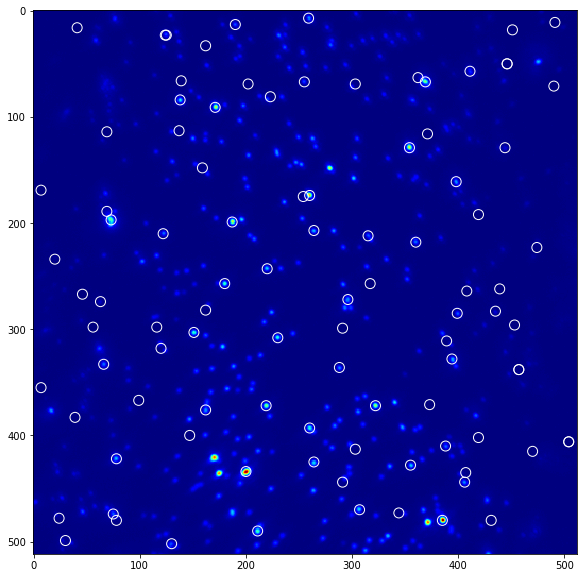

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(raw_xy, cmap='jet')
plt.scatter(coords[:, 2], coords[:, 1], s=100, marker='o', facecolors='none', edgecolor='w')

### 3D fitting